# Example notebook for collecting data, training and evaluating the model

## Importing

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.feature_selection import r_regression

from sklearn.neural_network import MLPRegressor

from sklearn.ensemble import BaggingRegressor

from sklearn.metrics import root_mean_squared_error as rmse

import salishsea_tools.viz_tools as sa_vi

## Files Reading

In [2]:
# The location of the files
ds = xr.open_dataset('/data/ibougoudis/MOAD/files/integrated_original.nc')
ds2 = xr.open_dataset('/data/ibougoudis/MOAD/files/external_inputs.nc')

# Downgrading the resolution
ds = ds.isel(
    y=(np.arange(ds.y[0], ds.y[-1], 5)), 
    x=(np.arange(ds.x[0], ds.x[-1], 5)))

ds2 = ds2.isel(
    y=(np.arange(ds2.y[0], ds2.y[-1], 5)), 
    x=(np.arange(ds2.x[0], ds2.x[-1], 5)))

# Selecting the first 2 years
dataset = ds.sel(time_counter = slice('2007-2-15', '2009-2-15'))
dataset2 = ds2.sel(time_counter = slice('2007-2-15', '2009-2-15'))


## Opening the second dataset and its features

<xarray.Dataset> Size: 263MB
Dimensions:                     (time_counter: 152, y: 180, x: 80)
Coordinates:
  * time_counter                (time_counter) datetime64[ns] 1kB 2007-02-15 ...
  * y                           (y) int64 1kB 0 5 10 15 20 ... 880 885 890 895
  * x                           (x) int64 640B 0 5 10 15 20 ... 380 385 390 395
Data variables: (12/15)
    Temperature_(0m-15m)        (time_counter, y, x) float64 18MB ...
    Temperature_(15m-100m)      (time_counter, y, x) float64 18MB ...
    Salinity_(0m-15m)           (time_counter, y, x) float64 18MB ...
    Salinity_(15m-100m)         (time_counter, y, x) float64 18MB ...
    Silicon                     (time_counter, y, x) float64 18MB ...
    Nitrate                     (time_counter, y, x) float64 18MB ...
    ...                          ...
    Microzooplankton            (time_counter, y, x) float64 18MB ...
    Mesozooplankton             (time_counter, y, x) float64 18MB ...
    Diatom_Production_Rate    

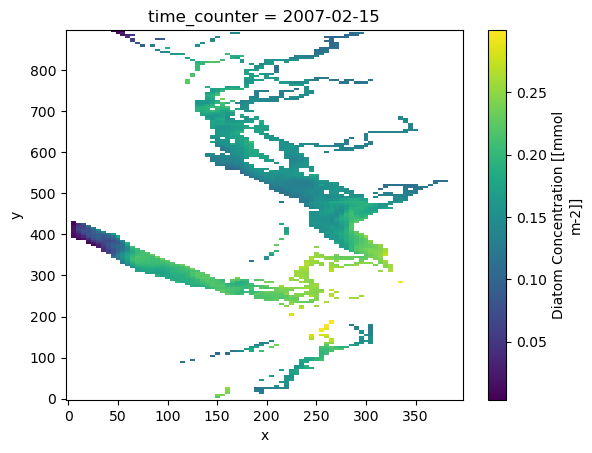

In [3]:
# Printing the features of the dataset
print(dataset)

# Plotting diatoms for the first day
dataset.Diatom[0].plot()


## Datasets Preparation

In [4]:
# Choosing the response
name = 'Diatom_Production_Rate'
units = '[mmol N m-2 s-1]'
category = 'Production rates'

# Here I am packing all of them in one variable, named inputs
inputs = np.stack([
    np.ravel(dataset2['Summation_of_solar_radiation']),
    np.ravel(dataset2['Mean_wind_speed']),
    np.ravel(dataset2['Mean_air_temperature']),
    np.ravel(dataset2['Mean_precipitation']),
    np.ravel(dataset2['Latitude']),
    np.ravel(dataset2['Longitude']),
    np.repeat(dataset.time_counter.dt.dayofyear, len(dataset.x)*len(dataset.y)),
    ])

# The response
targets = np.ravel(dataset[name])
   
# Removing of nans - boundaries
x = np.tile(dataset.x, len(dataset.time_counter)*len(dataset.y))
y = np.tile(np.repeat(dataset.y, len(dataset.x)), len(dataset.time_counter))

indx = np.where(np.isfinite(targets) & (x>10) & ((x>100) | (y<880)))

inputs = inputs[:,indx[0]]
targets = targets[indx[0]]

# Transpose to bring it to the format (samples, features)
inputs = inputs.transpose()

# 1st sample - grid box
inputs[0]


array([ 8.27515151e+02,  6.34831744e+00,  2.82497858e+02,  2.45690322e-04,
        4.71607437e+01, -1.22648041e+02,  4.60000000e+01])

## Training 

In [5]:
# First I define the model, with its transformers and regressor
model = TransformedTargetRegressor(regressor=make_pipeline(ColumnTransformer(
    transformers=[('drivers', StandardScaler(), [0,1,2,3]), ('spatial', KBinsDiscretizer(n_bins=255,encode='ordinal',strategy='quantile'), [4,5])],remainder='passthrough'),
    HistGradientBoostingRegressor(categorical_features=[4,5,6])),
    transformer=StandardScaler())

# Printing of the correlation coefficients
r = np.round(r_regression(inputs,targets),2)
dict_inputs = {'Summation_of_solar_radiation': r[0], 'Mean_wind_speed':r[1], 'Mean_air_temperature': r[2],
    'Mean_precipitation':r[3], 'Latitude':r[4], 'Longitude': r[5], 'Day_of_the_year': r[6]}

print('The correlation coefficients between each input and ' + name +  ' are: ' +str(dict_inputs))

# Creating a bagging regressor from the model, and training it
regr = BaggingRegressor(model, n_estimators=12, n_jobs=4).fit(inputs,targets)


The correlation coefficients between each input and Diatom_Production_Rate are: {'Summation_of_solar_radiation': 0.73, 'Mean_wind_speed': -0.23, 'Mean_air_temperature': 0.03, 'Mean_precipitation': -0.32, 'Latitude': 0.11, 'Longitude': 0.0, 'Day_of_the_year': 0.57}


## Testing

In [6]:
# Selecting one day in the future - the result will not look good, we do it just as an example
dataset = ds.sel(time_counter = slice('2023-4-20', '2023-4-20'))
dataset2 = ds2.sel(time_counter = slice('2023-4-20', '2023-4-20'))

# Same as before
inputs = np.stack([
    np.ravel(dataset2['Summation_of_solar_radiation']),
    np.ravel(dataset2['Mean_wind_speed']),
    np.ravel(dataset2['Mean_air_temperature']),
    np.ravel(dataset2['Mean_precipitation']),
    np.ravel(dataset2['Latitude']),
    np.ravel(dataset2['Longitude']),
    np.repeat(dataset.time_counter.dt.dayofyear, len(dataset.x)*len(dataset.y)),
    ])

# The response
targets = np.ravel(dataset[name])
   
# Removing of nans - boundaries
x = np.tile(dataset.x, len(dataset.time_counter)*len(dataset.y))
y = np.tile(np.repeat(dataset.y, len(dataset.x)), len(dataset.time_counter))

indx = np.where(np.isfinite(targets) & (x>10) & ((x>100) | (y<880)))

inputs = inputs[:,indx[0]]
targets = targets[indx[0]]

# Transpose to bring it to the format (samples, features)
inputs = inputs.transpose()

inputs[0]


array([ 1.93224970e+03,  4.12798663e+00,  2.78944955e+02,  7.77399527e-05,
        4.71607437e+01, -1.22648041e+02,  1.10000000e+02])

## Prediction and evaluation

In [7]:
predicted = regr.predict(inputs)

print('The correlation coefficient is:', np.corrcoef(targets,predicted)[0,1])
print('The rmse is:', rmse(targets,predicted))

# Creating the map for the predicted values
indx2 = np.full((len(dataset.y)*len(dataset.x)),np.nan)
indx2[indx] = predicted
model = np.reshape(indx2,(len(dataset.y),len(dataset.x)))

# Preparation of the dataarray 
model = xr.DataArray(model,
    coords = {'y': dataset.y, 'x': dataset.x},
    dims = ['y','x'],
    attrs=dict(units="mmol m-2"))


The correlation coefficient is: 0.8878144954631705
The rmse is: 5.436470097711012e-07


## Scatter plot

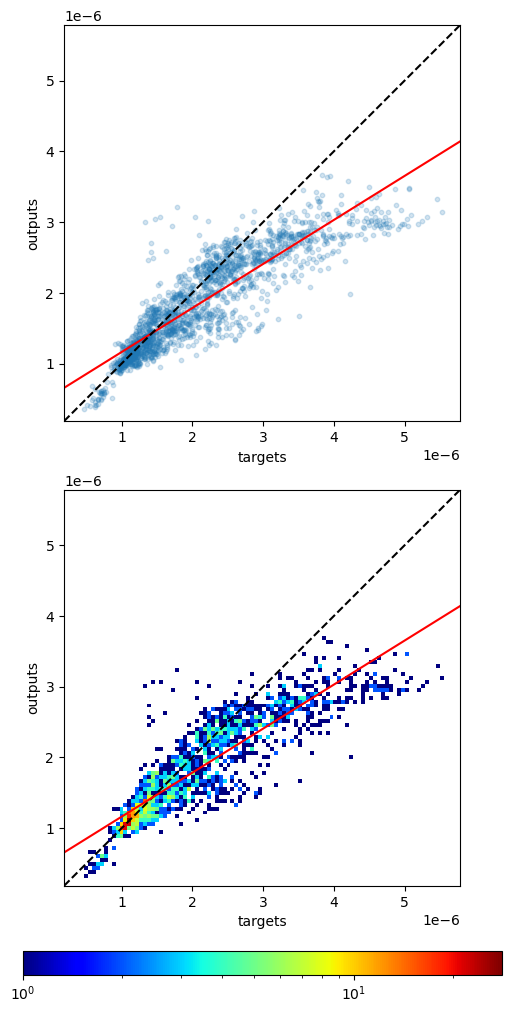

In [8]:
# compute slope m and intercept b
m, b = np.polyfit(targets, predicted, deg=1)

fig, ax = plt.subplots(2, figsize=(5,10), layout='constrained')

ax[0].scatter(targets, predicted, alpha = 0.2, s = 10)

lims = [np.min([ax[0].get_xlim(), ax[0].get_ylim()]),
    np.max([ax[0].get_xlim(), ax[0].get_ylim()])]

# plot fitted y = m*x + b
ax[0].axline(xy1=(0, b), slope=m, color='r')

ax[0].set_xlabel('targets')
ax[0].set_ylabel('outputs')
ax[0].set_xlim(lims)
ax[0].set_ylim(lims)
ax[0].set_aspect('equal')

ax[0].plot(lims, lims,linestyle = '--',color = 'k')

h = ax[1].hist2d(targets, predicted, bins=100, cmap='jet', 
    range=[lims,lims], cmin=0.1, norm='log')

ax[1].plot(lims, lims,linestyle = '--',color = 'k')

# plot fitted y = m*x + b
ax[1].axline(xy1=(0, b), slope=m, color='r')

ax[1].set_xlabel('targets')
ax[1].set_ylabel('outputs')
ax[1].set_aspect('equal')

fig.colorbar(h[3],ax=ax[1], location='bottom')

plt.show()

## Plotting

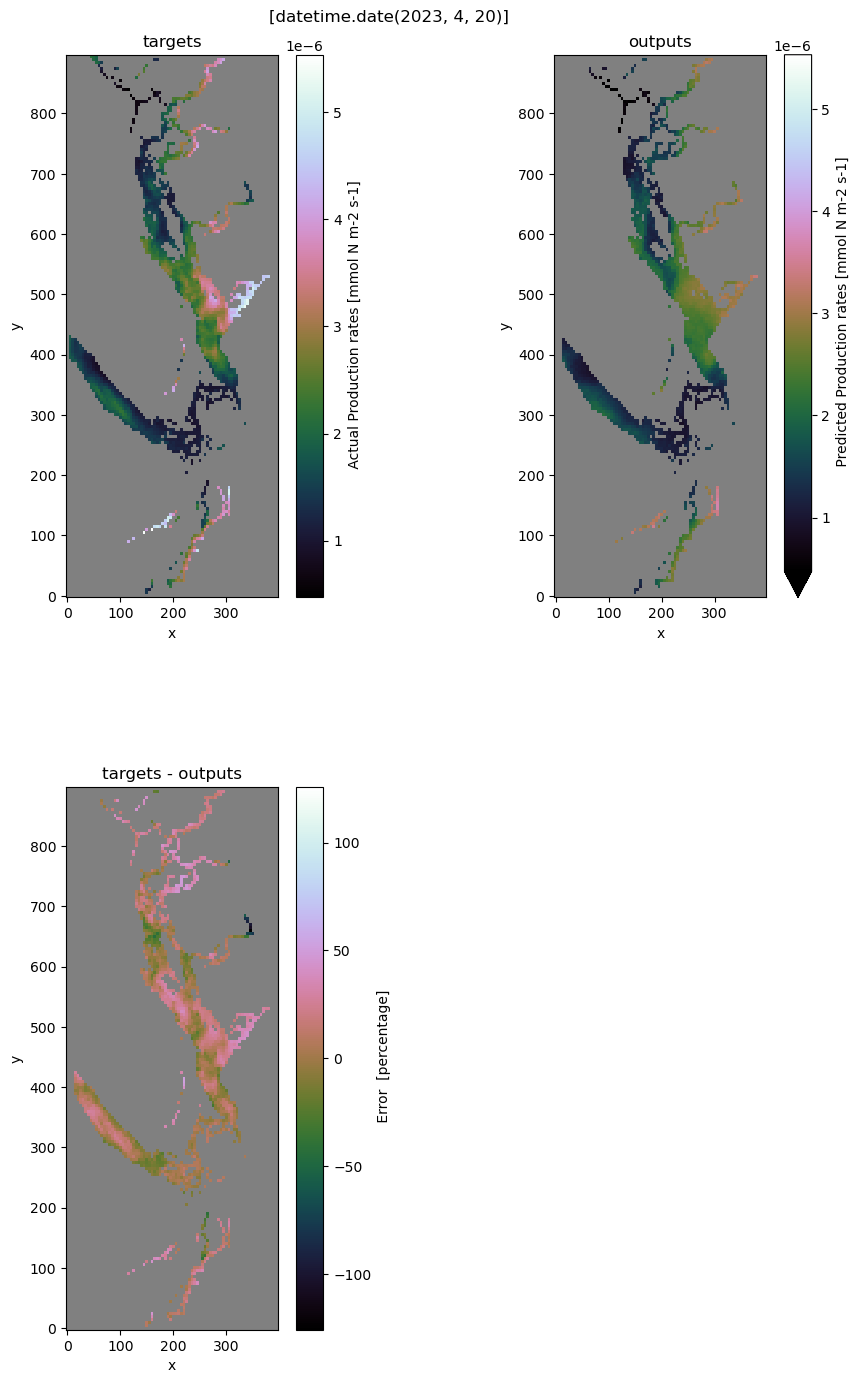

In [9]:
fig, ax = plt.subplots(2,2, figsize = (10,15))

cmap = plt.get_cmap('cubehelix')
cmap.set_bad('gray')

dataset[name].plot(ax=ax[0,0], cmap=cmap, vmin = targets.min(), vmax = targets.max(), cbar_kwargs={'label':' Actual ' +category + ' ' + units})
model.plot(ax=ax[0,1], cmap=cmap, vmin = targets.min(), vmax = targets.max(), cbar_kwargs={'label':' Predicted ' +category + ' ' + units })
((dataset[name]-model) / dataset[name] * 100).plot(ax=ax[1,0], cmap=cmap, cbar_kwargs={'label': ' Error  [percentage]'})

plt.subplots_adjust(left=0.1,
    bottom=0.1, 
    right=0.95, 
    top=0.95, 
    wspace=0.35, 
    hspace=0.35)

sa_vi.set_aspect(ax[0,0])
sa_vi.set_aspect(ax[0,1])
sa_vi.set_aspect(ax[1,0])

ax[0,0].title.set_text('targets')
ax[0,1].title.set_text('outputs')
ax[1,0].title.set_text('targets - outputs')
ax[1,1].axis('off')

fig.suptitle(dataset.time_counter.dt.date.values)

plt.show()
